In [1]:
import gymnasium as gym
from gymnasium.wrappers.vector import NumpyToTorch
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/zhutchens/projects/RL/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
env = gym.make_vec(
    'CartPole-v1', 
    num_envs = 4, 
)
env = NumpyToTorch(env, device = device)

Checking out environments

In [3]:
env.observation_space

Box([[-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]], [[4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]], (4, 4), float32)

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-1.9652    ,  0.19922113, -0.2085118 ,  0.6357048 ],
       [ 0.15289702,  0.6377103 , -0.28448763, -1.1593766 ],
       [ 4.696499  , -2.0384786 , -0.16170596, -0.47136858],
       [ 2.14805   ,  1.8556889 , -0.305653  , -1.1277945 ]],
      dtype=float32)

In [5]:
obs_sample.shape

(4, 4)

In [6]:
env.action_space

MultiDiscrete([2 2 2 2])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([0, 1, 0, 0])

In [8]:
states, info = env.reset()
states

tensor([[ 0.0246,  0.0140,  0.0491,  0.0102],
        [ 0.0457, -0.0213, -0.0329,  0.0179],
        [ 0.0135,  0.0059, -0.0283,  0.0089],
        [ 0.0376, -0.0137, -0.0137, -0.0290]])

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

tensor([[ 0.0249, -0.1818,  0.0493,  0.3179],
        [ 0.0453,  0.1743, -0.0326, -0.2850],
        [ 0.0136, -0.1888, -0.0281,  0.2925],
        [ 0.0374, -0.2087, -0.0143,  0.2593]])

In [11]:
rewards

tensor([1., 1., 1., 1.])

In [12]:
dones # done is when state successfully finished or passed

tensor([False, False, False, False])

In [14]:
terminated # terminated is when agent failed 

tensor([False, False, False, False])

Setting up networks

In [15]:
import random
import numpy as np
from src.ppo import *

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [16]:
actor = Actor(4, 2, 64).to(device)
critic = Critic(4, 1, 64).to(device)

In [17]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 2]))

In [18]:
test_sample = dist.sample()

In [19]:
dist.log_prob(test_sample)

tensor([-0.6973, -0.6841, -0.7835, -0.7332], grad_fn=<SqueezeBackward1>)

In [20]:
dist.log_prob(test_sample).exp()

tensor([0.4979, 0.5045, 0.4568, 0.4804], grad_fn=<ExpBackward0>)

In [21]:
critic.forward(obs_sample)

tensor([[-0.2575],
        [-0.3257],
        [-0.2271],
        [-0.3679]], grad_fn=<AddmmBackward0>)

In [22]:
# agent = Agent(actor, critic, 0.2, 0.99, 0.8, 0.5, 0.01, 0.0003, 0.0003, device, 8)
agent = Agent(actor, critic, 0.2, 0.99, 0.95, 0.5, 0.01, 0.0003, 0.001, device, 64)

In [23]:
train(env, agent, 4, 100, 512, 4, 'models/cartpole_agent.pt', True)

finished episode: 0
total reward: 1963.0
number of steps: 512
---------------
new best model... saving...
finished episode: 1
total reward: 1987.0
number of steps: 512
---------------
new best model... saving...
finished episode: 2
total reward: 2004.0
number of steps: 512
---------------
new best model... saving...
finished episode: 3
total reward: 2014.0
number of steps: 512
---------------
new best model... saving...
finished episode: 4
total reward: 2028.0
number of steps: 512
---------------
new best model... saving...
finished episode: 5
total reward: 2035.0
number of steps: 512
---------------
new best model... saving...
finished episode: 6
total reward: 2040.0
number of steps: 512
---------------
new best model... saving...
finished episode: 7
total reward: 2040.0
number of steps: 512
---------------
finished episode: 8
total reward: 2042.0
number of steps: 512
---------------
new best model... saving...
finished episode: 9
total reward: 2041.0
number of steps: 512
------------

Text(0, 0.5, 'reward')

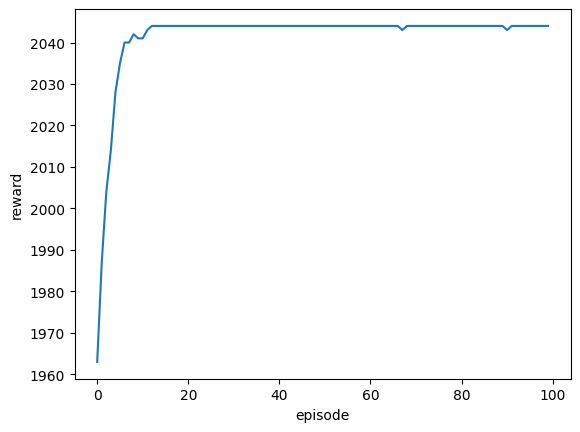

In [24]:
import matplotlib.pyplot as plt
plt.plot(agent.all_rewards)
plt.xlabel('episode')
plt.ylabel('reward')    

In [25]:
env.close()